# Importation de bibliothèques

In [116]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import datetime 
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

# Chargement du Dataset

In [117]:
cities = pd.read_csv('data/cities.csv')
providers = pd.read_csv('data/providers.csv')
stations = pd.read_csv('data/stations.csv')
ticket = pd.read_csv('data/ticket_data.csv')
cities.head()

,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [118]:
providers.tail()

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
222,8384,10,16,thalys,Thalys,True,True,False,True,train
223,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling
224,8387,30,NaN,vatry,Vatry,NaN,NaN,NaN,NaN,bus
225,8388,40,NaN,beauval,Beauval,NaN,NaN,NaN,NaN,bus
226,8389,12,NaN,idvroom,idVroom,False,False,False,False,carpooling


In [119]:
stations.head()

,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737


In [120]:
ticket.head()

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,7710,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


# Analyse univariée

Répartition des prix des billets

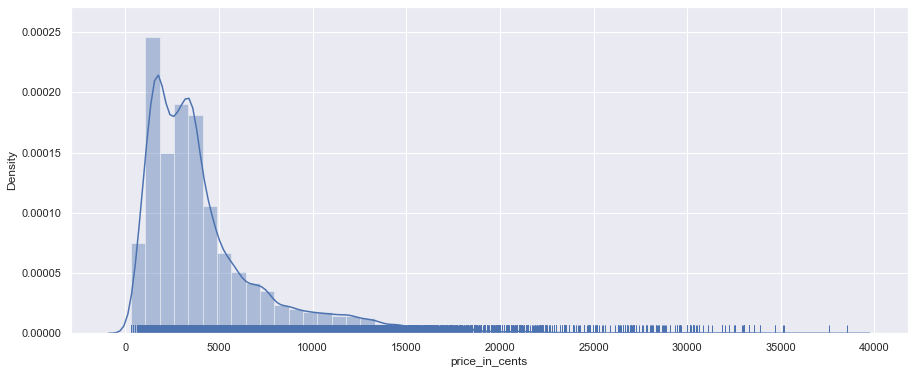

In [121]:
f,ax = plt.subplots(figsize=(15,6))
ax = sns.distplot(ticket['price_in_cents'],rug=True)
plt.show()

Prix minimum de billets par trajet

In [122]:
min_price = ticket.sort_values('price_in_cents', ascending=True).drop_duplicates(['o_city','d_city']).sort_index()
min_price.rename(columns = {'price_in_cents':'min_price'}, inplace = True)
min_price

,id,company,o_station,d_station,departure_ts,arrival_ts,min_price,search_ts,middle_stations,other_companies,o_city,d_city
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,1450,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
89,6795113,8385,NaN,NaN,2017-10-01 19:00:00+00,2017-10-01 21:50:00+00,1800,2017-10-01 03:40:04.769+00,NaN,NaN,524,1061
142,6795166,8385,NaN,NaN,2017-10-01 20:00:00+00,2017-10-01 20:50:00+00,600,2017-10-01 06:10:00.079+00,NaN,NaN,8398,485
149,6795173,8385,NaN,NaN,2017-10-01 11:40:00+00,2017-10-01 14:50:00+00,1100,2017-10-01 06:53:18.589+00,NaN,NaN,227,628
441,6795466,8385,NaN,NaN,2017-10-22 05:00:00+00,2017-10-22 09:40:00+00,2750,2017-10-01 07:51:59.829+00,NaN,NaN,1088,542
...,...,...,...,...,...,...,...,...,...,...,...,...
73324,6868349,8385,NaN,NaN,2017-10-28 08:00:00+00,2017-10-28 12:20:00+00,2750,2017-10-19 07:44:51.015+00,NaN,NaN,628,488
73332,6868357,8385,NaN,NaN,2017-10-27 06:40:28+00,2017-10-27 09:50:28+00,1750,2017-10-19 07:46:05.98+00,NaN,NaN,649,528
73491,6868516,8385,NaN,NaN,2017-10-21 10:00:00+00,2017-10-21 11:10:00+00,850,2017-10-19 08:21:35.214+00,NaN,NaN,46,171
73851,6868876,9,279.0,518.0,2017-10-26 17:20:00+00,2017-10-27 08:50:00+00,1800,2017-10-19 10:02:57.732+00,"{506,506}",{13},628,737


Prix maximum de billets par trajet

In [123]:
max_price = ticket.sort_values('price_in_cents', ascending=False).drop_duplicates(['o_city','d_city']).sort_index()
max_price.rename(columns = {'price_in_cents':'max_price'}, inplace = True)
max_price

,id,company,o_station,d_station,departure_ts,arrival_ts,max_price,search_ts,middle_stations,other_companies,o_city,d_city
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,13500,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
98,6795122,13,481.0,283.0,2017-10-01 06:45:00+00,2017-10-01 18:45:00+00,6490,2017-10-01 03:40:07.057+00,"{249,249}",{13},524,1061
135,6795159,13,581.0,860.0,2017-10-06 03:55:00+00,2017-10-06 13:00:00+00,3490,2017-10-01 05:37:19.182+00,"{304,304}",{9},424,126
142,6795166,8385,NaN,NaN,2017-10-01 20:00:00+00,2017-10-01 20:50:00+00,600,2017-10-01 06:10:00.079+00,NaN,NaN,8398,485
444,6795469,8385,NaN,NaN,2017-10-22 17:00:00+00,2017-10-22 22:30:00+00,3800,2017-10-01 07:51:59.83+00,NaN,NaN,1088,542
...,...,...,...,...,...,...,...,...,...,...,...,...
73331,6868356,13,953.0,891.0,2017-10-25 22:35:00+00,2017-10-26 09:35:00+00,3080,2017-10-19 07:45:47.095+00,"{797,797}",{13},709,649
73343,6868368,13,763.0,953.0,2017-10-22 06:05:00+00,2017-10-22 22:00:00+00,5690,2017-10-19 07:46:48.803+00,"{225,225}",{13},504,709
73566,6868591,9,10865.0,904.0,2017-10-22 15:30:00+00,2017-10-23 00:45:00+00,2600,2017-10-19 08:52:53.388+00,"{10144,10642}",{8372},46,171
73841,6868866,8376,6799.0,518.0,2017-10-26 17:14:00+00,2017-10-26 20:59:00+00,7900,2017-10-19 10:02:56.047+00,"{582,582}",{8376},628,737


Prix moyen de billets par trajet

In [124]:
df2 = pd.DataFrame(ticket,columns= ['price_in_cents','o_city','d_city'])
moy_price = (df2.groupby((['o_city','d_city'] )).mean().reset_index(drop=True))
moy_price.rename(columns = {'price_in_cents':'moy_price'}, inplace = True)
df3 = pd.DataFrame(max_price,columns= ['id','company','o_station','d_station','departure_ts','arrival_ts','search_ts','middle_stations','other_companies','o_city','d_city']).reset_index()
df3.insert(7, "moy_price", moy_price, True)
df3

,index,id,company,o_station,d_station,departure_ts,arrival_ts,moy_price,search_ts,middle_stations,other_companies,o_city,d_city
0,3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,20320.000000,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
1,98,6795122,13,481.0,283.0,2017-10-01 06:45:00+00,2017-10-01 18:45:00+00,11755.000000,2017-10-01 03:40:07.057+00,"{249,249}",{13},524,1061
2,135,6795159,13,581.0,860.0,2017-10-06 03:55:00+00,2017-10-06 13:00:00+00,4042.666667,2017-10-01 05:37:19.182+00,"{304,304}",{9},424,126
3,142,6795166,8385,NaN,NaN,2017-10-01 20:00:00+00,2017-10-01 20:50:00+00,2797.500000,2017-10-01 06:10:00.079+00,NaN,NaN,8398,485
4,444,6795469,8385,NaN,NaN,2017-10-22 17:00:00+00,2017-10-22 22:30:00+00,864.626866,2017-10-01 07:51:59.83+00,NaN,NaN,1088,542
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432,73331,6868356,13,953.0,891.0,2017-10-25 22:35:00+00,2017-10-26 09:35:00+00,4204.861111,2017-10-19 07:45:47.095+00,"{797,797}",{13},709,649
1433,73343,6868368,13,763.0,953.0,2017-10-22 06:05:00+00,2017-10-22 22:00:00+00,6950.000000,2017-10-19 07:46:48.803+00,"{225,225}",{13},504,709
1434,73566,6868591,9,10865.0,904.0,2017-10-22 15:30:00+00,2017-10-23 00:45:00+00,5300.000000,2017-10-19 08:52:53.388+00,"{10144,10642}",{8372},46,171
1435,73841,6868866,8376,6799.0,518.0,2017-10-26 17:14:00+00,2017-10-26 20:59:00+00,688.888889,2017-10-19 10:02:56.047+00,"{582,582}",{8376},628,737


durée min par trajet

In [125]:
ticket['durée']=pd.to_datetime(ticket["arrival_ts"]) - pd.to_datetime(ticket["departure_ts"])
min_duree = ticket.sort_values('durée', ascending=True).drop_duplicates(['o_city','d_city']).sort_index()
min_duree

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,durée
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,4550,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,0 days 06:10:00
96,6795120,8385,NaN,NaN,2017-10-01 22:10:00+00,2017-10-02 00:50:00+00,1900,2017-10-01 03:40:04.769+00,NaN,NaN,524,1061,0 days 02:40:00
142,6795166,8385,NaN,NaN,2017-10-01 20:00:00+00,2017-10-01 20:50:00+00,600,2017-10-01 06:10:00.079+00,NaN,NaN,8398,485,0 days 00:50:00
443,6795468,8385,NaN,NaN,2017-10-22 16:10:00+00,2017-10-22 20:00:00+00,3100,2017-10-01 07:51:59.83+00,NaN,NaN,1088,542,0 days 03:50:00
451,6795476,9,795.0,9156.0,2017-10-20 21:25:00+00,2017-10-21 13:20:00+00,5990,2017-10-01 08:10:32.141+00,"{279,279}",{13},535,7168,0 days 15:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73478,6868503,8385,NaN,NaN,2017-10-20 19:20:00+00,2017-10-20 20:30:00+00,700,2017-10-19 08:16:20.054+00,NaN,NaN,33,188,0 days 01:10:00
73491,6868516,8385,NaN,NaN,2017-10-21 10:00:00+00,2017-10-21 11:10:00+00,850,2017-10-19 08:21:35.214+00,NaN,NaN,46,171,0 days 01:10:00
73807,6868832,8376,585.0,6246.0,2017-10-23 05:34:00+00,2017-10-23 07:43:00+00,9600,2017-10-19 09:53:35.571+00,"{5836,5836}",{8376},485,628,0 days 02:09:00
73840,6868865,8376,6799.0,518.0,2017-10-26 07:14:00+00,2017-10-26 10:58:00+00,7250,2017-10-19 10:02:56.047+00,"{582,582}",{8376},628,737,0 days 03:44:00


durée max par trajet

In [126]:
ticket['durée']=pd.to_datetime(ticket["arrival_ts"]) - pd.to_datetime(ticket["departure_ts"])
max_duree = ticket.sort_values('durée', ascending=False).drop_duplicates(['o_city','d_city']).sort_index()
max_duree

,id,company,o_station,d_station,departure_ts,arrival_ts,price_in_cents,search_ts,middle_stations,other_companies,o_city,d_city,durée
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,7400,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,1 days 07:57:00
109,6795133,13,481.0,283.0,2017-10-02 06:45:00+00,2017-10-03 05:00:00+00,3690,2017-10-01 03:40:34.561+00,"{249,249}",{13},524,1061,0 days 22:15:00
142,6795166,8385,NaN,NaN,2017-10-01 20:00:00+00,2017-10-01 20:50:00+00,600,2017-10-01 06:10:00.079+00,NaN,NaN,8398,485,0 days 00:50:00
439,6795464,8385,NaN,NaN,2017-10-22 17:00:00+00,2017-10-22 22:30:00+00,3800,2017-10-01 07:51:00.029+00,NaN,NaN,1088,542,0 days 05:30:00
446,6795471,9,795.0,9156.0,2017-10-19 13:50:00+00,2017-10-20 19:15:00+00,4790,2017-10-01 08:10:19.424+00,"{279,279}",{13},535,7168,1 days 05:25:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73492,6868517,9,10865.0,569.0,2017-10-21 15:30:00+00,2017-10-22 16:40:00+00,1800,2017-10-19 08:21:37.622+00,"{10144,279}",{13},46,171,1 days 01:10:00
73806,6868831,8376,585.0,6797.0,2017-10-23 05:34:00+00,2017-10-24 23:07:00+00,4900,2017-10-19 09:53:35.57+00,"{5836,5836}",{8376},485,628,1 days 17:33:00
73850,6868875,13,279.0,518.0,2017-10-26 07:05:00+00,2017-10-27 13:40:00+00,2280,2017-10-19 10:02:57.732+00,"{565,565}",{13},628,737,1 days 06:35:00
73914,6868964,8385,NaN,NaN,2017-10-20 20:10:10+00,2017-10-21 00:00:10+00,1200,2017-10-19 10:15:30.856+00,NaN,NaN,200,485,0 days 03:50:00


Durée moyen par trajet

# Exploration de données

répartition des stations suivant latitude

In [127]:
stations['unique_name'] = stations.iloc[:, 1:-2].sum(axis=1)

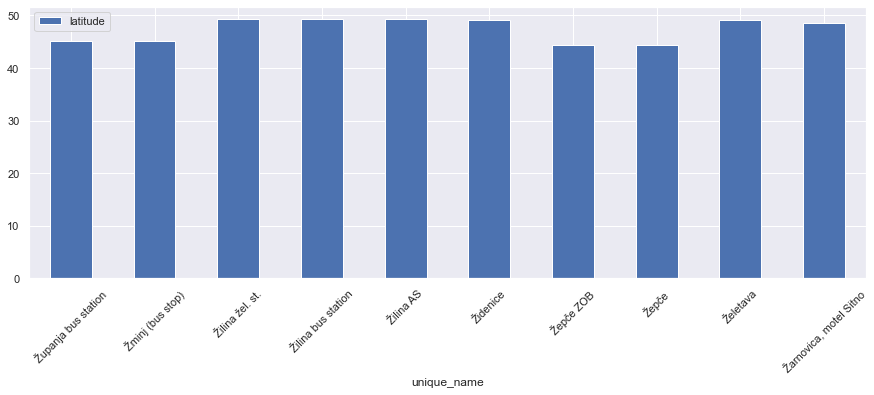

In [128]:
g=stations.sort_values(by='unique_name', ascending=False)[:10].plot.bar(x='unique_name', y='latitude', rot=45, figsize=(15,5))

Prédiction prix ticket

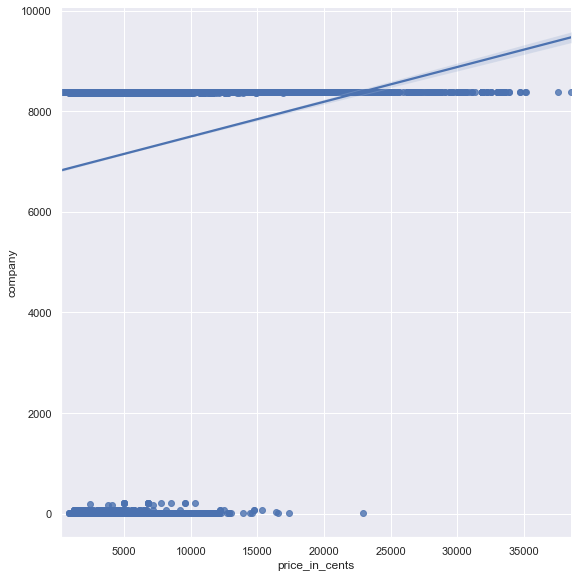

In [156]:
sns.set(style="darkgrid")
sns.lmplot( x = 'price_in_cents', y = 'company', data = ticket, height=8)

In [130]:
X = ticket['price_in_cents'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = ticket['company'].values.reshape(-1, 1)  # values converts it into a numpy array

Train model pour la prediction du future ticker prix par company

In [135]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,random_state=1)
model = LinearRegression().fit(xtrain,ytrain)

prediction de prix de ticket selon company

In [137]:
pticket = float(input())
y_pred = model.predict([[pticket]])
c = float(y_pred)
print('',c)

5000
 7145.4866944476


prix moyen selon le type de transport

In [185]:
lite_t = pd.DataFrame(ticket,columns= ['company','price_in_cents']).sort_values('company', ascending=True)
prov = providers.sort_values('company_id', ascending=True)
prov['price_in_cents']=lite_t['price_in_cents']
moy_price = (providers.groupby((['transport_type'] )).mean().reset_index(drop=True))
moy_per_transport = prov.sort_values('transport_type', ascending=False).drop_duplicates(['transport_type']).reset_index(drop=True)
moy_per_transport['price_in_cents']=moy_price['price_in_cents']
moy_per_transport.rename(columns = {'price_in_cents':'prix_moy_per_transport'}, inplace = True)
moy_per_transport

,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type,prix_moy_per_transport
0,8378,10,3,tramtrain,Tramtrain,False,False,True,False,train,2310.700935
1,8385,11,NaN,bbc,Blablacar,False,False,False,False,carpooling,1800.000000
2,14,6,NaN,driivme,DriiveMe,False,False,False,False,car,2650.000000
3,34,9,149,berlinShuttle,Berlin Shuttle,False,False,False,False,bus,2390.000000
